# 3D FWI in Stride

This notebook adapts Stride's 2D FWI example to work with a 3D breast model.

Start mosaic runtime:

In [1]:
import mosaic

await mosaic.interactive('on', num_workers=2, log_level='info')
runtime = mosaic.runtime()

Listening at <CommsManager object at 4876355536, uid=monitor, address=192.168.5.106, port=3000, state=connected>HEAD            Listening at <CommsManager object at 4873378640, uid=head, address=192.168.5.106, port=3004, state=connected>


MONITOR         Listening at <NODE:0 | WORKER:0-2>
WORKER:0:0      (ShotID 0) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:0      Apple's x86 clang found, OpenMP is not supported.
WORKER:0:1      (ShotID 1) Spatial grid spacing (0.500 mm | 3.973 PPW) is higher than dispersion limit (0.397 mm | 5.000 PPW)
WORKER:0:1      Apple's x86 clang found, OpenMP is not supported.


Problem definition:

Create the problem definition, fill it with transducers and their geometry (using one of the default geometry utils), create shots for each transducer, and load breast model (the true sound velocity at each point).

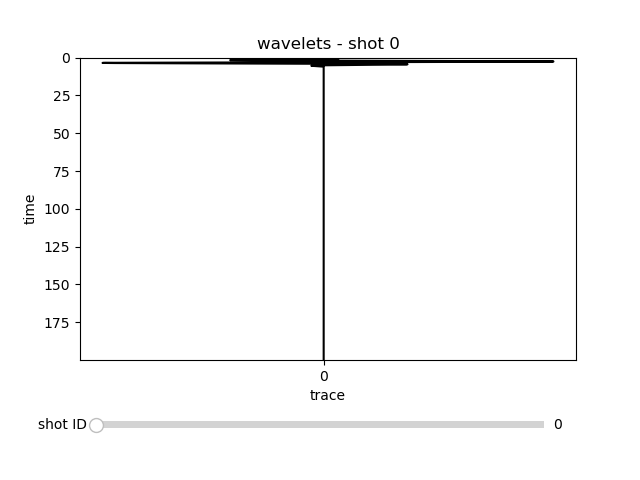

In [6]:
from stride.utils import fetch, wavelets
from stride import Space, Time, Grid
import numpy as np
%matplotlib widget

space = Space(shape=(356, 385, 160), extra=(50, 50, 50), absorbing=(40, 40, 40), spacing=(0.5e-3, 0.5e-3, 0.5e-3))
time = Time(start=0, step=0.08e-6, num=2500)

grid = Grid(space, time)

from stride import Problem

problem = Problem(name='breast3D', space=space, time=time)

# Create transducers
# the default option will create a single point transducer
problem.transducers.default()

# Create geometry
radius = ((space.limit[0] - 30e-3) / 2,
            (space.limit[1] - 05e-3) / 2,
            (space.limit[2] - 05e-3))
centre = (space.limit[0] / 2,
            space.limit[1] / 2,
            space.limit[2])
# a default ellipsoid geometry will be used in this case
num_locations = 1024
problem.geometry.default('ellipsoidal', num_locations, radius, centre,
                        theta=np.pi, threshold=0.5)

from stride.utils import wavelets

# Populate acquisitions with default shots
problem.acquisitions.default()

# Create wavelets
f_centre = 0.50e6
n_cycles = 3

for shot in problem.acquisitions.shots:
    shot.wavelets.data[0, :] = wavelets.tone_burst(f_centre, n_cycles, time.num, time.step)

from stride import ScalarField

# Create medium
vp_true = ScalarField(name='vp', grid=grid)
fetch('anastasio3D', dest='data/anastasio3D-TrueModel.h5')
vp_true.load('data/anastasio3D-TrueModel.h5')

problem.medium.add(vp_true)

# Plot all components of the problem
problem.plot()

Modelling Operator:

Choosing a PDE to run our forward problem, in this case the isotropic acoustic wave equation.

In [7]:
from stride import IsoAcousticDevito

pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

Forward problem -- running a simulation to generate an observed data set:

The observed data set will later be used to calculate how far off our model is from the actual data.

Here we use Stride's utility function "forward". If you want to see more detailed code, take a look at the 2d example notebook.

In [8]:
from stride import forward

# Run default forward workflow
await forward(problem, pde, vp_true, dump=False)

OSError: dlopen(/var/folders/ss/r77hzyqj3xj6lyxgzh7gfn8w0000gn/T/devito-jitcache-uid501/9fe55ea3e74879d5034de170610c959e57ea2d6c.dylib, 0x0006): tried: '/var/folders/ss/r77hzyqj3xj6lyxgzh7gfn8w0000gn/T/devito-jitcache-uid501/9fe55ea3e74879d5034de170610c959e57ea2d6c.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/var/folders/ss/r77hzyqj3xj6lyxgzh7gfn8w0000gn/T/devito-jitcache-uid501/9fe55ea3e74879d5034de170610c959e57ea2d6c.dylib' (no such file), '/var/folders/ss/r77hzyqj3xj6lyxgzh7gfn8w0000gn/T/devito-jitcache-uid501/9fe55ea3e74879d5034de170610c959e57ea2d6c.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/private/var/folders/ss/r77hzyqj3xj6lyxgzh7gfn8w0000gn/T/devito-jitcache-uid501/9fe55ea3e74879d5034de170610c959e57ea2d6c.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/private/var/folders/ss/r77hzyqj3xj6lyxgzh7gfn8w0000gn/T/devito-jitcache-uid501/9fe55ea3e74879d5034de170610c959e57ea2d6c.dylib' (no such file), '/private/var/folders/ss/r77hzyqj3xj6lyxgzh7gfn8w0000gn/T/devito-jitcache-uid501/9fe55ea3e74879d5034de170610c959e57ea2d6c.dylib' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64'))

Starting model: 

Unlike in the forward problem, the speed of sound field is unknown to us at this point. We need to choose a starting assumption to begin optimizing from. Here we assume a homogenous speed of 1500 m/s (~water's speed of sound).

In [ ]:
vp = ScalarField.parameter(name='vp', grid=grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Imaging operators:

Define operators for our loss function, processing our source wavelets and the modelled/observed data traces, and an optimizer to update the speed of sound model after each iteration (here we use gradient descent).

We also limited the speed of sound to between 1400 and 1700 m/s, which will need to change when we introduce bone.

In [ ]:
from stride import L2DistanceLoss 

loss = L2DistanceLoss.remote(len=runtime.num_workers)

from stride import ProcessWavelets, ProcessObserved, ProcessWaveletsObserved, ProcessTraces

process_wavelets = ProcessWavelets.remote(len=runtime.num_workers)
process_observed = ProcessObserved.remote(len=runtime.num_workers)
process_wavelets_observed = ProcessWaveletsObserved.remote(len=runtime.num_workers)
process_traces = ProcessTraces.remote(len=runtime.num_workers)

from stride import GradientDescent, ProcessGlobalGradient, ProcessModelIteration

step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

Inverse problem -- estimating the speed of sound:

We use a multi-frequency approach, starting with lower frequencies and then moving to higher frequencies for more detail. This is done by dividing the optimization into blocks, each with a max frequency.

During each iteration, only a random subset of the shots will actually be used. 

Here we use the utility function "adjoint" to run this optimization loop. If you want to see more detailed code, take a look at the 2d example notebook.

In [ ]:
from stride import OptimisationLoop

# Clear the previous Devito operators
await pde.clear_operators()

optimisation_loop = OptimisationLoop()

# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
max_freqs = [0.3e6, 0.4e6]

num_blocks = len(max_freqs)
num_iters = 4

for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
    await adjoint(problem, pde, loss,
        optimisation_loop, optimiser, vp,
        num_iters=num_iters,
        select_shots=dict(num=15, randomly=True),
        f_max=freq)

vp.plot()

Tear down the mosaic runtime:

In [ ]:
await mosaic.interactive('off')